# TIE Reconstruction Template
For solving the transport of intensity equation and finding magnetic induction from through-focal-series TEM images. 
  
Authors: Arthur McCray  
Based on code by CD Phatak  
V1.2, ANL, March 2020

## Refer to readme file for instructions

Required files:

    TIE_reconstruct.py  -- main code that sets up and solves TIE  
    TIE_params.py       -- class file for reconstruction parameters  
    microscopes.py      -- class file for microscope parameters
    TIE_helper.py       -- functions for loading data, making masks, etc.   
    colorwheel.py       -- makes the colorwheel vectorfield representation image  
  
    stack_align.ipynb   -- interfaces with imagej to align images, not required 
                           but very helpful
  

### Future development
* Apply polynomial fitting for the derivative

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from microscopes import Microscope
from TIE_helper import *
from TIE_reconstruct import TIE, SITIE
# will throw warning from hyperspy. You can also use the Qt5 backend with:
# %matplotlib qt
# This will get rid of the warning but won't work when running remotely. 

## Loading the data

Please download the example dataset from: https://petreldata.net/mdf/detail/cphatak_pytie_example_v1.1/  
This contains a full through focus series (tfs) with the sample in both flipped and unflipped orientations. 

If you have both a flip and unflip stack your raw images should be in two folders:  

    datafolder/    flip/     -im1.dm3  
                             -im2.dm3  
                                ...  
                             +im1.dm3  
                             +im2.dm3  
                                ...  
                             0im.dm3    
                   unflip/   -im1.dm3  
                             -im2.dm3  
                                 .  
                                 .  
                             +im1.dm3  
                             +im2.dm3  
                                 .  
                                 .  
                              0im.dm3  
                   flsfile.fls 
                   full_align.tif  
  
If your flip and unflip filenames aren't the same you can also have two fls files, just add the argument  
load_data(... , flip_fls_file = "your/flip/fls/path")

However if you have just one stack (no flip stack) then your data should be in a folder labeled 'tfs' 

    datafolder/    tfs/      -im1.dm3  
                             -im2.dm3  
                                ...  
                             +im1.dm3  
                             +im2.dm3  
                                ...  
                              0im.dm3    
                   flsfile.fls 
                   full_align.tif  

In [2]:
# fill in the appropriate path *** 
data_loc = '../../ex_recon_data/PyTIE_MDF_data/'

fls_name = "dataset1.fls"
flip_fls_name = None # just one fls file
stack_name = 'd1_full_align.tif' 
flip = True # there is/isn't a flipped tfs and flip_dm3stack

dm3stack, flip_dm3stack, ptie = load_data(data_loc,
                                          fls_name, 
                                          stack_name, 
                                          flip,
                                          flip_fls_name)

print("Defocus values: ", ptie.defvals)

# microscope object
altem = Microscope(E=200e3, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)

loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/-5160960.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/-2211840.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/-1105920.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/0_800x.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/+1105920.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/+2211840.dm3
loading unflip: ../../ex_recon_data/PyTIE_MDF_data/unflip/+5160960.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/-5160960.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/-2211840.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/-1105920.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/0_800x.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/+1105920.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/+2211840.dm3
loading flip: ../../ex_recon_data/PyTIE_MDF_data/flip/+5160960.dm3
Scale: 5.1066 nm/pix
done

Defocus val

In [3]:
np.set_printoptions(linewidth=110) 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [ ]:
# Scroll through slices 
show_stack(dm3stack + flip_dm3stack)

## Select a smaller image size (optional)
* Default is 1/4 image size centered in the middle
* Drag mask and corners to get the section you want to reconstruct
    - It's finnicky, if the corner isn't dragging, try moving mouse cursor more slowly and make sure you're on the corner. 
    - if it still isn't working you can change ptie.roi by hand (it's in nm not pixels, convert with ptie.scale which is nm/pix)

<IPython.core.display.Javascript object>


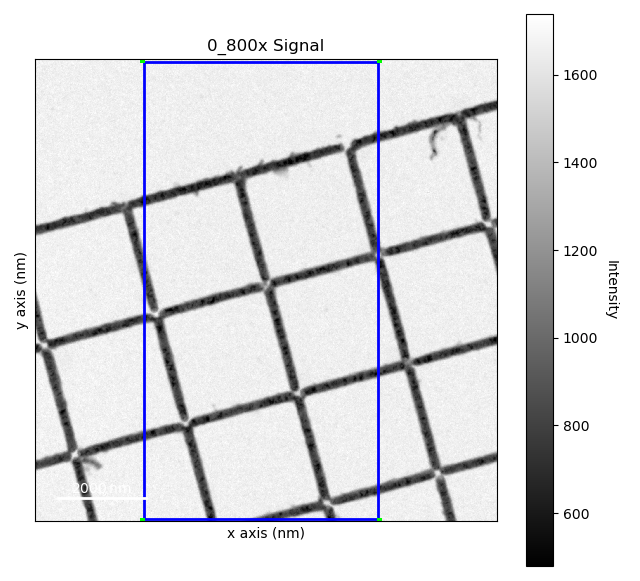

In [4]:
ptie.select_region()

In [8]:
### Run this when the region is what you want. 
ptie.crop_dm3s()

The new images will be cropped (in pixels)
left: 484 , right: 1523 , top: 12 , bottom: 2040
New dimensions will be: (2028, 1039)

Does this work? (y/n):
Or you can reset to the original full images (reset):
y

Your images are now: (2028, 1039)
Changes can continue to be made by moving/updating the region,
but you have to run this again for them to take affect.



In [ ]:
show_stack(ptie.dm3stack+ptie.flip_dm3stack, ptie)

## The actual phase reconstruction

* Set which focus values you want to use with index i 
* images will be saved as /dataloc/images/dataname_focusval_imagename.tif
* if you want to symmetrize the images set sym = True
* if you want to run with a Tikhonov frequency
    - set qc = value that you want, (currently needs large values ~>10) or 
    - set qc = 'percent' and it will use 15% of q (not that it makes much difference) or
    - leave qc = None and it will run normally
* if you don't want to save the images (you'll still be able to look at them here) set save = False

In [5]:
print('actual defocus values: ', ptie.defvals)
print('reconstruct with   i = ', '    0    ', '   1   ', '     2 ...')

actual defocus values:  [199065.6, 398131.2, 928972.8]
reconstruct with   i =      0        1         2 ...


In [6]:
i = 2 # Select which defocus value you'll be working with if 3-point deriv 
dataname = 'example' 
sym = False
qc = 0.001 #is a reasonable value for the test dataset, matters more on some data
save = False
longitudinal_deriv = False # If false, uses central difference (3 point)
print(f'Set to reconstruct for defocus value: {ptie.defvals[i]} nm ')

Set to reconstruct for defocus value: 928972.8 nm 


Aligning for defocus value:  928972.8  with both flip/unflip tfs.
Reconstructing with Tikhonov value: 0.001
Calling TIE solver



<IPython.core.display.Javascript object>


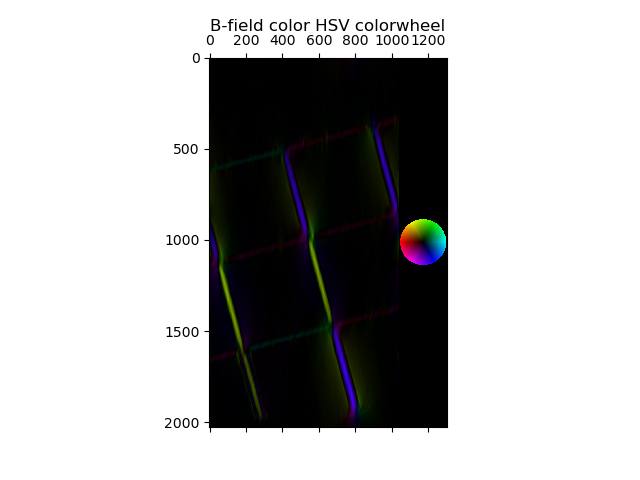

Phase reconstruction completed.


In [9]:
results = TIE(i, ptie, altem, 
                     dataname = dataname, 
                     sym=sym, 
                     qc = qc, 
                     save=save,
                     long_deriv = longitudinal_deriv)

In [ ]:
show_im(results_long['phase_m'], 'magnetic phase shift')

In [ ]:
show_im(results['phase_e'], 'electrostatic phase shift')

## Looking at the data
You can of course just look at the data where it's saved, but if you don't want to save it and move it to a local computer you can view the images here, they're all in the results dictionary. 
* Results: 
    - 'color_b' -- the colorwheel representation of the magnetization
    - 'byt' and 'bxt' -- the y and x components of the magnetization
    - 'phase_m' and 'phase_e' -- the magnetic and electric phase shifts respectively 
    - 'dIdZ_m'  and 'dIdZ_e' -- the magnetic and electric derivatives 
    - 'inf_im' -- the infocus image (averaged from flip and unflip)

In [ ]:
## Show the image with a four-fold colorwheel instead of hsv
from colorwheel import color_im
show_im(color_im(results['bxt'], results['byt'], hsvwheel=False))


## Single Image Reconstruction (SITIE)

In [ ]:
## TODO

### Arrow overlay  
A basic little thing for overlaying arrows on the colormap and saving it to your /images directory. The main parameters that need to be adjusted are  
- a : sampling scale for the arrows 
- scale : arrow length
- width : arrow width

It's a bit slow because it's creating a lot of arrows, and I have it using mpl patches instead of quiver (patches is better for in-notebook viewing because the arrows have a fixed scale, but I'm not sure if that matters for saving images)

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

In [ ]:
x0 = 1
x1 = -1
y0 = 1
y1 = -1


mag_x = results['bxt'][y0:y1,x0:x1]
mag_y = results['byt'][y0:y1,x0:x1]

px = x1 - x0
py = y1 - y0

fig, ax = plt.subplots(figsize = (12, 12))

X = []
Y = []
U = []
V = []

a = 10
for i in range(0,np.shape(mag_x)[0],a):
    for j in range(0,np.shape(mag_y)[1],a):        
        Y.append(i)
        X.append(j)
        U.append(mag_x[i,j])
        V.append(mag_y[i,j])

scale = 4.5
width = 0.3

patches_dir = []
for x,y, dx, dy in zip(X,Y,U,V):
    dx = dx * scale
    dy = dy * scale
    arrow = mpatches.FancyArrowPatch((x-dx/2, y-dy/2), (x+dx/2, y+dy/2))
    patches_dir.append(arrow)

p1 = PatchCollection(patches_dir, color = 'w', edgecolor = 'w', lw = width)

cim = color_im(mag_x, mag_y, hsvwheel=True)
ax.imshow(cim)

ax.add_collection(p1)

defval = defvals[0]
plt.axis('off')
plt.savefig(ptie.data_loc + 'images/' + dataname + '_' +
    str(defval) + '_' + f'arrows{scale}' + '.png',
           dpi = 1000, bbox_inches='tight')

plt.show()


--- end notebook ---